In [ ]:
import awkward as awk
import matplotlib.pyplot as plt
import numpy as np

In [2]:
f = "output/MINERvA_Dipole_M4.70e-01_mu1.25e-06_example.parquet"
data = awk.from_parquet(f)
POT = 2.25e22

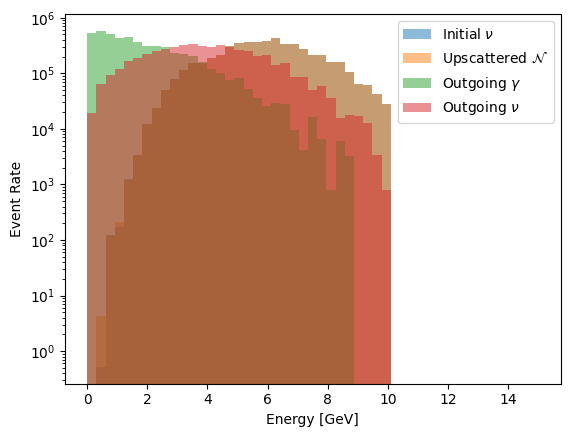

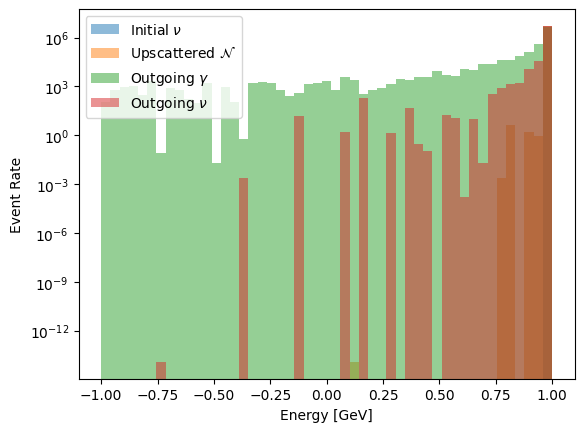

In [4]:
# Kinematic distributions

# initial nu
nu_flag = data["primary_type"]=="ParticleType.NuMu"
nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

# N
N_flag = data["primary_type"]=="ParticleType.N4"
N_momenta = np.squeeze(data["primary_momentum"][N_flag])

# gamma
gamma_flag = data["secondary_types"]=='ParticleType.Gamma'
gamma_momenta = data["secondary_momenta"][gamma_flag]
# mask out entries that are not gamma
gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])

# nu out
nuout_flag = data["secondary_types"]=='ParticleType.NuLight'
nuout_momenta = data["secondary_momenta"][nuout_flag]
# mask out entries that are not nuout
nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

kwargs = {"bins":np.linspace(0,15,50),
          "weights":data["event_weight"]*POT,
          "alpha":0.5}

# Energy
plt.hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
plt.hist(N_momenta[:,0],**kwargs,label=r"Upscattered $\mathcal{N}$")
plt.hist(gamma_momenta[:,0],**kwargs,label=r"Outgoing $\gamma$")
plt.hist(nuout_momenta[:,0],**kwargs,label=r"Outgoing $\nu$")
plt.legend()
plt.semilogy()
plt.xlabel("Energy [GeV]")
plt.ylabel("Event Rate")
plt.show()

# Angle
kwargs["bins"] = np.linspace(-1,1,50)
def CosTheta(momenta,axis=3):
    return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
plt.hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
plt.hist(CosTheta(N_momenta),**kwargs,label=r"Upscattered $\mathcal{N}$")
plt.hist(CosTheta(gamma_momenta),**kwargs,label=r"Outgoing $\gamma$")
plt.hist(CosTheta(nuout_momenta),**kwargs,label=r"Outgoing $\nu$")
plt.legend()
plt.semilogy()
plt.xlabel("Energy [GeV]")
plt.ylabel("Event Rate")
plt.show()


In [21]:
dec_flag = data["primary_type"]=='ParticleType.N4'
gamma_flag = data["secondary_types"]=='ParticleType.Gamma'
print(data["in_fid"])
fid_flag = data["event_weight"]<3e-24

plt.hist2d(np.array(data["vertex"][~dec_flag][:,0,0]),
           np.array(data["vertex"][~dec_flag][:,0,1]),
           bins=(np.linspace(-5,10,50),
                 np.linspace(-2,2,50)))
plt.show()

plt.hist2d(np.array(data["vertex"][dec_flag])[:,0,0],
           np.array(data["vertex"][dec_flag])[:,0,1],
           bins=(np.linspace(-5,30,50),
                 np.linspace(-2,2,50)))
plt.show()

plt.hist2d(np.array(data["vertex"][dec_flag])[fid_flag][:,0,0],
           np.array(data["vertex"][dec_flag])[fid_flag][:,0,1],
           bins=(np.linspace(20,30,50),
                 np.linspace(-2,2,50)))
plt.show()
plt.hist(data["event_weight"])
plt.loglog()
plt.show()

FieldNotFoundError: no field 'in_fid' in record with 10 fields

This error occurred while attempting to slice

    <Array [{event_weight: 1.15e-20, ...}, ...] type='10000 * {event_weight...'>

with

    'in_fid'